In [1]:
from model import *


In [2]:
# load data
frames=md.load_xtc("./singlesim/it50k/eql2.xtc",top="./singlesim/it50k/conf.gro")

In [3]:
# showing the molecule
molecule = frames[0]
atomic_numbers = [atom.element.atomic_number for atom in molecule.top.atoms]
water = Atoms(positions=molecule.xyz[0], numbers=atomic_numbers)
show_ase(water)



NGLWidget()

In [4]:
features=[]
for molecule in tqdm(frames):
    atomic_numbers = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T
    vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T
    mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T
    positions = molecule.xyz[0]*10
    
    positions = positions - positions[0]
    
    node_features = np.concatenate((positions,vdwr,atomic_numbers),axis=1)
    features.append(node_features)
    
features = np.array(features)

100%|██████████| 50001/50001 [00:01<00:00, 36553.62it/s]


In [5]:
print("Node Features:\n",features[50000])

Node Features:
 [[ 0.          0.          0.          0.152       8.        ]
 [ 0.928936   -0.22790241  0.03701782  0.12        1.        ]
 [-0.43196297 -0.800951   -0.29684734  0.12        1.        ]
 [ 0.05301476 -0.10975456 -0.02771759  0.          0.        ]]


In [6]:
# create edge list
from_list = []

to_list = []
for edge in frames.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [7]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [8]:
graphs = []


In [9]:
for node_feature in tqdm(features):
    graph = data.Data(x=torch.from_numpy(node_feature),edge_index=torch.from_numpy(edge_list))
    graphs.append(graph)
    

100%|██████████| 50001/50001 [00:00<00:00, 55735.32it/s]


In [10]:
print(graphs[0])

Data(x=[4, 5], edge_index=[2, 4])


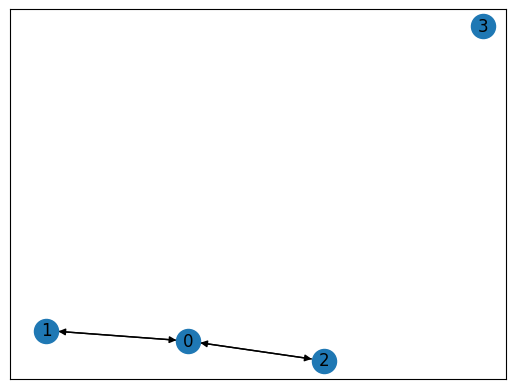

In [11]:
vis = to_networkx(graphs[0])
nx.draw_networkx(vis, with_labels=True)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50001/50001 [00:00<00:00, 190476.51it/s]


In [13]:
import os
in_channels = graph.num_features
out_channels = 3
n_atoms = 20
lr = 1e-3
n_epochs = 500
batch_size=256
test_train_split = 0.8
model_name = "IntraGVAE_l3_final.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels,batch_size,n_atoms),
                VariationalGCNDecoder(out_channels, in_channels,batch_size,n_atoms))
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [14]:
split = int(test_train_split * len(graphs_device))
train_loader = DataLoader(graphs_device[:split], batch_size=batch_size,shuffle=True)
test_loader = DataLoader(graphs_device[split:], batch_size=batch_size,shuffle=True)

In [15]:
print("Using:",device )
print("total_graphs:", len(graphs_device))
print("Graphs in a batch:", batch_size)
print("Train Graphs Batches:",len(train_loader),f"(Total graphs: {len(train_loader)*batch_size})")
print("Test Graphs Batches:",len(test_loader),f"(Total graphs: {len(test_loader)*batch_size})")
print("Model Specifics:\n",model)

Using: cpu
total_graphs: 50001
Graphs in a batch: 256
Train Graphs Batches: 157 (Total graphs: 40192)
Test Graphs Batches: 40 (Total graphs: 10240)
Model Specifics:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(5, 15)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(80, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 20, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)


In [16]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
     
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]


        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)


        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)

#         positionLoss.backward()
        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader) ,position_loss_all / len(train_loader)

In [17]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]
        
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
   
        
        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [18]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        train_total_loss, train_feature_loss, train_edge_loss,train_position_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss,test_position_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if(early_stopper.early_stop(test_total_loss)):
            print("Early Stopping")
            break

        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_position_losses.append(train_position_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_position_losses.append(test_position_loss)
        
        scheduler.step()

    torch.save(model,"./models/"+model_name)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x15 and 45x15)